# Turbulent jet and Internal Tide configuration

see link to **?forcing description? (to do)**

Control variables:

- south/north density profiles and contrast (`jet_weigth`)

- relaxation time scale

- Coriolis $\beta$ parameter


In [1]:
from glob import glob

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as op
import crocosi.plot as cplt

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:56780 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


## Load data

In [3]:
#root_path = '/home/datawork-lops-osi/equinox/itbalt/'
#root_path = '/home1/scratch/aponte/'
#root_path = '/home/c11-data/Test_aponte/fsturb/'
root_path = '/home1/datawork/aponte/'

run = 'jet_cfg1_wp75_4km_0a1000j/'

r = pp.Run(root_path+run, open_nc=['surf', 'his'], 
           verbose=True)

r['surf'] = r['surf'].assign_coords(time=r['surf'].time_instant.chunk({'time':None}))
r['his'] = r['his'].assign_coords(time=r['his'].time_counter.chunk({'time':None}))
#pout = r.params_output

Analysing directory /home1/datawork/aponte/jet_cfg1_wp75_4km_0a1000j/
Found 10 segments
Found 10 grid files
Found 20 surf files
Found 50 his files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'surf', 'his']
Grid size: (L ,M, N) = (258, 722, 50)


In [45]:
# bug ??
ds0 = r['surf'].rename({'time_instant': 'time'})
ds1 = ds.assign_coords(time=r['surf'].time_instant) #.chunk({'time':None}))

In [46]:
ds0.sel(time=slice(100,300,100)).time.values

array([101., 201.])

In [47]:
ds1.sel(time=slice(100,300,100)).time.values

array([100., 200., 300.])

---

## utils

In [5]:
# to be updated
def plot_Fy(p, ax=None, scale=1, ls='--', color='k', **kwargs):
    #p = r.params_output
    #ymid = p['fst_ymid']*scale
    #ywid = p['fst_ywid']*scale
    #if ax is not None:
    #    ax.axhline(ymid-ywid, ls=ls, color=color)
    #    ax.axhline(ymid+ywid, ls=ls, color=color)
    #else:
    #    plt.axhline(ymid+ywid, ls=ls, color=color)
    #    plt.axhline(ymid-ywid, ls=ls, color=color)
    pass

---

## bulk statistics

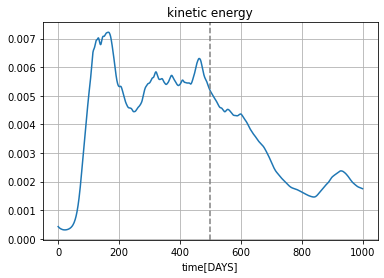

In [4]:
ax = r.stats['KINETIC_ENRG'].plot(title='kinetic energy')
ax.grid()
ax.axvline(500, color='0.5', ls='--')

In [5]:
ds = r['surf']
ds['u2'] = ds.u**2
ds['v2'] = ds.v**2
ds_mean = ds.mean(dim=['x_rho','x_u','time']).persist()

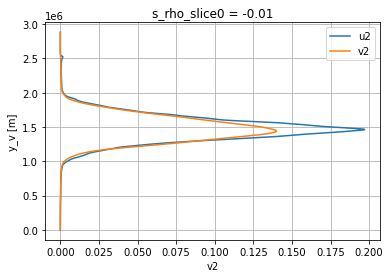

In [6]:
ax = plt.subplot(111)
ds_mean.u2.plot(y='y_rho', ax=ax, label='u2')
ds_mean.v2.plot(y='y_v', ax=ax, label='v2')
ax.legend()
ax.grid()
#plot_Fy(pout)

In [7]:
u2_meanx = (r['surf'].u**2).mean(dim=['x_u']).persist()

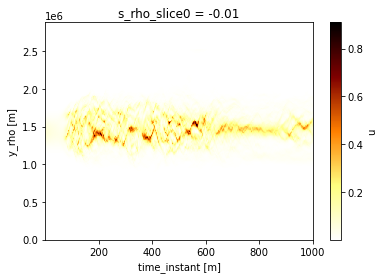

In [8]:
u2_meanx.plot(x='time', y='y_rho', cmap='afmhot_r') #.values.shape
#plot_Fy(pout)

--- 

## pictures

### sea level

In [9]:
t_surf_coarse = slice(100,1000,200)

hmap_kwargs = {'col': 'time', 'col_wrap': 5, 
               'subplot_kws': {'aspect':'equal'},
               'aspect':.5, 'figsize':(10,5)}

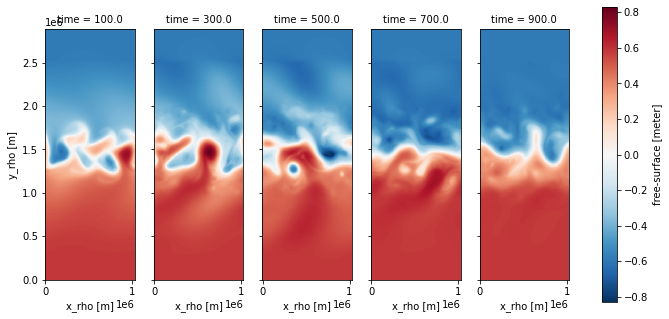

In [10]:
hdl = (r['surf']['ssh'].sel(time=t_surf_coarse)
         .plot(x='x_rho', y='y_rho', **hmap_kwargs)
       )
#plot_Fy(pout, ax=hdl.axes[0,-1])

### surface zonal velocity

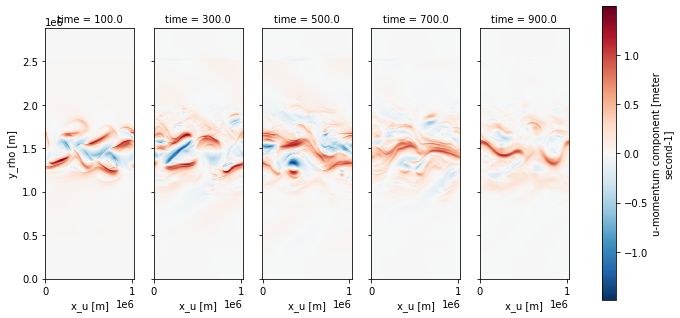

In [11]:
hdl = (r['surf']['u'].sel(time=t_surf_coarse)
         .plot(x='x_u', y='y_rho', **hmap_kwargs)
)
#plot_Fy(pout, ax=hdl.axes[0,-1])

### surface relative vorticity

In [12]:
u, v = r['surf']['u'], r['surf']['v']
zeta = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))

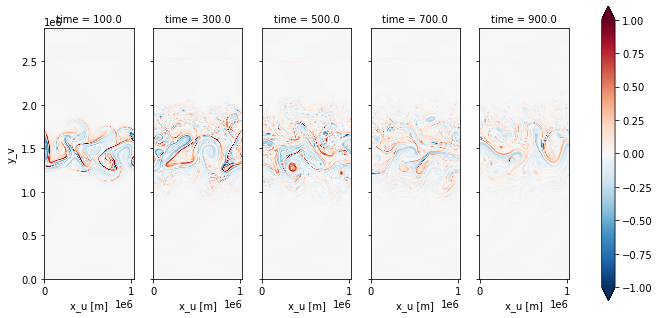

In [13]:
f_rho = r['grid'].f + r['grid'].x_rho*0.
f_zeta = r.xgrid.interp(r.xgrid.interp(f_rho, 'eta'), 'xi')
hdl = ((zeta/f_zeta).sel(time=t_surf_coarse)
         .plot(x='x_u', y='y_v', vmin=-1., vmax=1., cmap='RdBu_r', **hmap_kwargs)
)
#plot_Fy(pout, ax=hdl.axes[0,-1])

---

## vertical slices

In [14]:
z_u = r.get_z(zeta=r['his'].ssh_t_dirac, hgrid='u')
ds = r['his'].assign_coords(z_u = z_u)

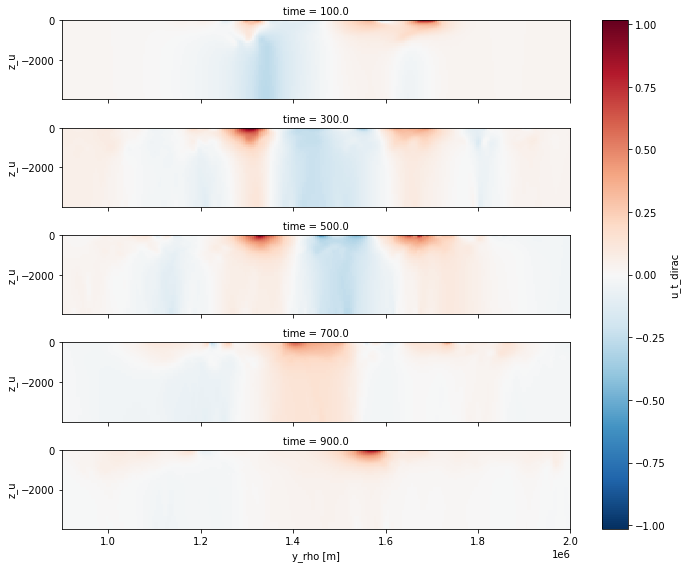

In [30]:
(ds.u_t_dirac
 .sel(time=t_his_coarse, method='nearest')
 .isel(x_u=0)
 .plot(x='y_rho', y='z_u', 
       xlim=(900*1e3,2000*1e3),
       figsize=(10,8),
       col='time', col_wrap=1)
)

---

## wavenumber spectra

In [31]:
u = r['surf']['u'].sel(time=slice(0,None,5))
v = r['surf']['v'].sel(time=slice(0,None,5))

In [32]:
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi', boundary='extend')
                            .chunk({'x_rho': None, 'y_rho': None}),
                            dim=['x_rho','y_rho'], 
                            detrend='constant', window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta', boundary='extend')
                            .chunk({'x_rho': None, 'y_rho': None}),
                            dim=['x_rho','y_rho'], 
                            detrend='constant', window=True).compute()
ekehat = .5*(uhat2 + vhat2).mean('time').persist()

In [33]:
kx = (ekehat['freq_x_rho']*1e3).rename('kx [1/km]')
ky = (ekehat['freq_y_rho']*1e3).rename('ky [1/km]')

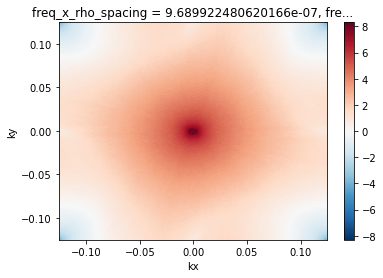

In [34]:
np.log10(ekehat.assign_coords(kx=kx, ky=ky)).plot(x='kx', y='ky') #, subplot_kws={'aspect':'equal'}, aspect=.5, figsize=(5,5))

In [35]:
ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)

In [36]:
def add_slope(k_start=None, k_end=None, level_start=None, slope=None):
    if isinstance(slope, list):
        [add_slope(k_start, k_end, level_start, ls) for ls in slope]
    else:
        k = np.arange(k_start,k_end,(k_end-k_start)/3.)
        y = level_start*(k/k[0])**slope
        plt.plot(k, y, 'k')
        plt.text(k[-1], y[-1], ' {i}'.format(i=slope))

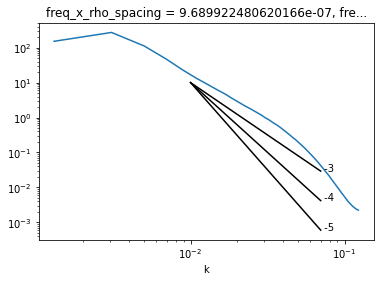

In [37]:
ekehat_iso.plot(x='k', xscale='log', yscale='log')

add_slope(k_start=1e-2, k_end=1e-1, level_start=1e1, slope=[-3, -4, -5])

In [38]:
u = r['surf']['u'].sel(time=slice(50,200,50))
v = r['surf']['v'].sel(time=slice(50,200,50))
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi', boundary='extend')
                            .chunk({'x_rho': None, 'y_rho': None}),
                            dim=['x_rho','y_rho'], 
                            detrend='constant', 
                            window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta', boundary='extend')
                            .chunk({'x_rho': None, 'y_rho': None}),
                            dim=['x_rho','y_rho'], 
                            detrend='constant', 
                            window=True).compute()
ekehat = .5*(uhat2 + vhat2)

ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)
ekehat_iso = ekehat_iso.persist()

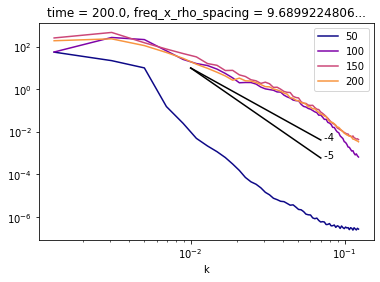

In [39]:
#hdl = ekehat_iso.plot(x='k', hue='time', xscale='log', yscale='log')
#
colors = cplt.get_cmap_colors(ekehat_iso.time.size)
for t, c in zip(ekehat_iso.time, colors):
    ekehat_iso.sel(time=t).plot(x='k', color=c,
                                xscale='log', yscale='log',
                                label='{t}'.format(t=int(t)))
plt.legend()
#add_slope(1e-2, 1e-1, 1e-2, [-4,-5])
add_slope(k_start=1e-2, k_end=1e-1, level_start=1e1, slope=[-4, -5])

---

## modal projection

In [ ]:
# requires diag_store to be run first

---

In [69]:
cluster.close()